In [1]:
import time, os, glob, cv2, random,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#print(tf.config.list_physical_devices('GPU'))

In [2]:
machines = ['fan','pump','slider','valve']
kinds = ['normal', 'abnormal']
labels = ["abnormal", "normal"]
img_size = 400
inputshape = (1000,400,3)
rate = 0.2
rootpath = f'/mnt/Mel/Mel/fan'

In [3]:
def name_path(name):
    paths = []
    for machine in machines:
        paths.append(rootpath+f'{machine}/{name}')
    return paths

file_names = {'normal': name_path(kinds[0]),'abnormal': name_path(kinds[1])}

def RaTe(num,rate):
    t = int(num * rate)
    R = []
    while(1):
        for i in range(num):
            if t == 0:
                R.append(0)
            else:
                r = random.random()
                if r <= rate:
                    R.append(1)
                    t -= 1
                else:
                    R.append(0)
        if t == 0:
            break
        else:
            continue
    return R

In [4]:
time_start = time.time()  # time = 0

train_data=[]
test_data=[]

for label in labels:
    path = os.path.join(rootpath, label)   # create path
    class_num = labels.index(label)   # get the classification  (0 or a 1). 0=Abnormal 1=normal
    l = len(os.listdir(path))
    R = RaTe(l, rate)
    i=0
    for img in os.listdir(path):      # iterate over each image per two of them
        if R[i] == 0:
            img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size + 600))  # Reshaping images to preferred size
            train_data.append([resized_arr, class_num])
        else:
            img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size + 600))  # Reshaping images to preferred size
            test_data.append([resized_arr, class_num])
        i += 1
        
train = np.array(train_data,dtype=object)
test = np.array(test_data,dtype=object)

time_end = time.time()
minute = (time_end - time_start) // 60
second = (time_end - time_start) % 60
print('\nData Processing', minute, 'min ', second, ' sec')


Data Processing 2.0 min  36.95179605484009  sec


In [5]:
print(train[0,0].shape)
print(test[0,0].shape)
print('Train len',len(train))
print('Test len',len(test))

(1000, 400, 3)
(1000, 400, 3)
Train len 4454
Test len 1096


In [6]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
# Normalize the data
x_train = np.array(x_train) 
x_test = np.array(x_test) 
print('Next')
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
print('Next')
x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
print('Next')

Next
Next
Next


In [7]:
datagen = ImageDataGenerator(
    rescale=1. / 255,    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)
print('Next')

Next


In [8]:
###model###model###model###model###model###model
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=inputshape))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 400, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 200, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 50, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 50, 64)       0

2022-05-09 15:56:27.097465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 15:56:27.820500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22319 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [9]:
time_end = time.time()

opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , 
              metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_test, y_test))

time_start = time.time()  # time = 0
time_model = time.time()
minute = (time_end - time_start) // 60
second = (time_end - time_start) % 60
print('\nModel Time cost', minute, 'min ', second, ' sec')

2022-05-09 15:56:38.506080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Epoch 1/500


2022-05-09 15:56:40.058850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-05-09 15:56:42.379950: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


140/140 [==============================] - 19s 105ms/step - loss: 5.0619 - accuracy: 0.6075 - val_loss: 0.9876 - val_accuracy: 0.7308
Epoch 2/500
140/140 [==============================] - 11s 79ms/step - loss: 2.1909 - accuracy: 0.6199 - val_loss: 0.9351 - val_accuracy: 0.7308
Epoch 3/500
140/140 [==============================] - 11s 81ms/step - loss: 1.1205 - accuracy: 0.6520 - val_loss: 0.6033 - val_accuracy: 0.7308
Epoch 4/500
140/140 [==============================] - 11s 81ms/step - loss: 0.6300 - accuracy: 0.7146 - val_loss: 0.5819 - val_accuracy: 0.7308
Epoch 5/500
140/140 [==============================] - 11s 81ms/step - loss: 0.5948 - accuracy: 0.7263 - val_loss: 0.5816 - val_accuracy: 0.7308
Epoch 6/500
140/140 [==============================] - 11s 81ms/step - loss: 0.5950 - accuracy: 0.7295 - val_loss: 0.5808 - val_accuracy: 0.7308
Epoch 7/500
140/140 [==============================] - 11s 81ms/step - loss: 0.5851 - accuracy: 0.7308 - val_loss: 0.5803 - val_accuracy: 0.7

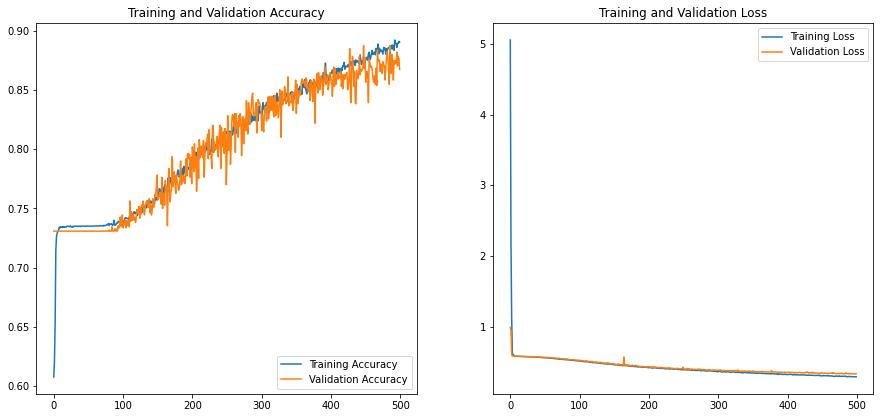

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('acc.png')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('loss.png')
plt.show()

In [12]:
acc = np.array(acc)
np.save('acc.npy',acc)
val_acc = np.array(val_acc)
np.save('val_acc.npy',val_acc)
loss = np.array(loss)
np.save('loss.npy',loss)
val_loss = np.array(val_loss)
np.save('val_loss.npy',val_loss)